# FoodApp User Behavior Analysis Test A/A/B

## 📄 Project Description

Investigation of user behavior for a food‑product startup’s mobile/web application. The analysis is divided into two parts:

1. **Funnel Analysis**  
   - Tracks the user journey through key stages (e.g., landing, product view, cart, checkout).  
   - Determines drop‑off rates at each stage and quantifies how many users reach the purchase stage versus those who stall earlier.

2. **A/A/B Font Test**  
   - Compares two control groups (A1 & A2) using the existing font and one test group (B) using a proposed new font.  
   - Verifies consistency between A1 and A2 to assess experiment noise and estimate data requirements for future tests.  
   - Measures conversion rates and engagement metrics to determine whether the new font has a significant impact on user behavior.

All analyses leverage the same dataset, reflecting real‑world practice where experiments run concurrently with ongoing behavioral tracking. <br> <br>
**Note: Experiment number 246 and 247 are the control groups (A/A), and 248 is the test group(B).** 


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

## Data Preprocessing and Cleaning

In [2]:
# Load the dataset
df = pd.read_csv('datsets/logs_exp_us.csv', sep='\t')
display(df.head())
display(df.info())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

In [3]:
# Change column names
df = df.rename(columns={
    'EventName': 'event',
    'DeviceIDHash': 'user_id',
    'EventTimestamp': 'timestamp',
    'ExpId': 'exp_id'
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   user_id    244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   exp_id     244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
#verify if there are null values or duplicated rows
print(df.isnull().sum())
print('-----------')
print(df.duplicated().sum())
#Delete duplicated rows
df = df.drop_duplicates()

event        0
user_id      0
timestamp    0
exp_id       0
dtype: int64
-----------
413


In [5]:
# Convert timestamp to datetime and extract date
df['event_dt'] = pd.to_datetime(df['timestamp'], unit='s')
df['event_date'] = df['event_dt'].dt.date
display(df.head())
print(df.info())


,event,user_id,timestamp,exp_id,event_dt,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   exp_id      243713 non-null  int64         
 4   event_dt    243713 non-null  datetime64[ns]
 5   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB
None


## Study and analyze the data

How many events are in the logs?

In [6]:
display('Total events: ', len(df))

'Total events: '

243713

How many users are there in the records?

In [7]:
print('Number of users: ', df['user_id'].nunique())

Number of users:  7551


What is the average number of events per user?

In [8]:
events_per_user = len(df) / df['user_id'].nunique()
print(f'Average events per user: {events_per_user:.2f}')

Average events per user: 32.28


What time period do the data cover?

In [9]:
min_time = df['event_dt'].min()
max_time = df['event_dt'].max()
print(f'The time range is: {min_time} → {max_time}')

The time range is: 2019-07-25 04:43:36 → 2019-08-07 21:15:17


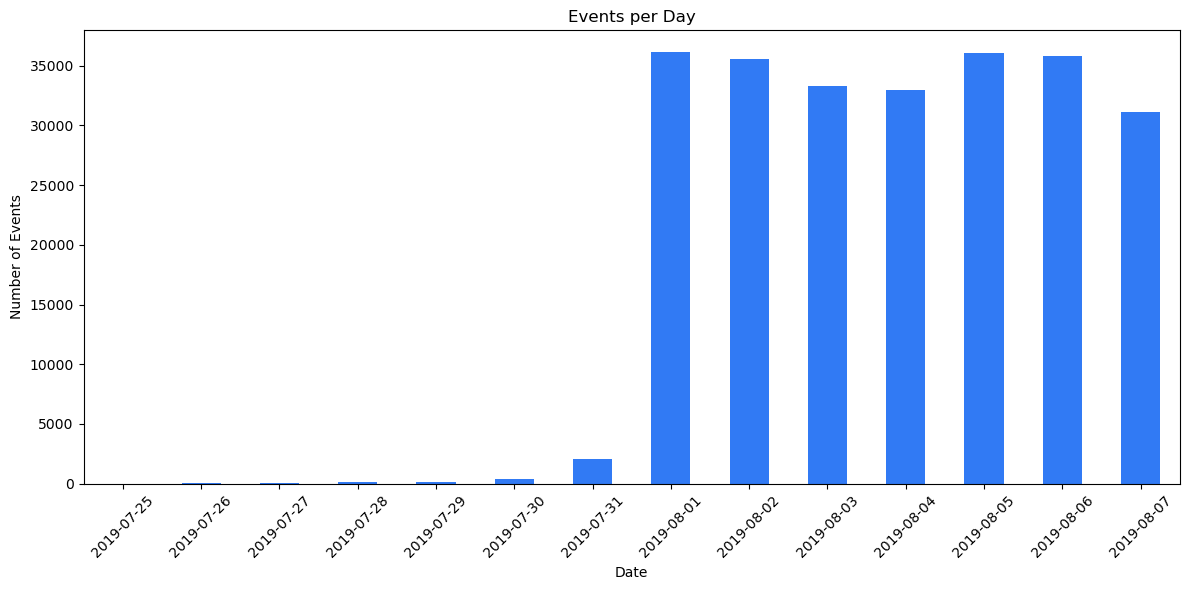

In [10]:
#histogram of events by day
plt.figure(figsize=(12, 6))
event_counts_by_day = df['event_date'].value_counts().sort_index()
event_counts_by_day.plot(kind='bar',
                        title='Events per Day',
                        xlabel='Date',
                        ylabel ='Number of Events',
                        color='#317af4')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The Dataframe could be filtered by data from 2019-07-31

In [11]:
cut_day= '2019-07-31'
df['event_date'] = pd.to_datetime(df['event_date'])
df_filtered = df[df['event_date'] >= cut_day]
print("Start:", df_filtered['event_date'].min())
print("End:", df_filtered['event_date'].max())



Start: 2019-07-31 00:00:00
End: 2019-08-07 00:00:00


Check if whe lost a lot of data

In [12]:
total_eventos = len(df)
eventos_filtrados = len(df_filtered)
print('Total events: ', total_eventos)
print('Events after we filtered: ', eventos_filtrados)
print('Events removed: ', total_eventos-eventos_filtrados)
print('Percentage removed: ', round(((1 - eventos_filtrados / total_eventos) * 100), 2), "%")

Total events:  243713
Events after we filtered:  242917
Events removed:  796
Percentage removed:  0.33 %


We remove less than 1% nothing too significant

In [13]:
#verify we have enough events in each group
display(df_filtered['exp_id'].value_counts())

exp_id
248    85309
246    79922
247    77686
Name: count, dtype: int64

## Study the event funnel

### What events are in the logs and their frequency of occurrence

In [14]:
#star usinnf th filtered dataframe
df_filtered.head()

,event,user_id,timestamp,exp_id,event_dt,event_date
797,MainScreenAppear,3670880358399219515,1564535506,247,2019-07-31 01:11:46,2019-07-31
798,OffersScreenAppear,3799109751993694887,1564536064,248,2019-07-31 01:21:04,2019-07-31
799,Tutorial,1126021718529336913,1564536731,247,2019-07-31 01:32:11,2019-07-31
800,MainScreenAppear,4293428370257583636,1564539558,248,2019-07-31 02:19:18,2019-07-31
801,MainScreenAppear,4567464647598975872,1564540410,247,2019-07-31 02:33:30,2019-07-31


In [15]:
# Study the event funnel
top_events = df_filtered['event'].value_counts()
display(top_events)

event
MainScreenAppear           118578
OffersScreenAppear          46707
CartScreenAppear            42560
PaymentScreenSuccessful     34058
Tutorial                     1014
Name: count, dtype: int64

In [16]:
#users per event
total_users = df['user_id'].nunique()
funnel = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']
users_per_event = df.groupby('event')['user_id'].nunique().sort_values(ascending=False).loc[funnel]
display(users_per_event)

event
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Name: user_id, dtype: int64

We remove tutorial step as it is not important

### Retention by stage

In [17]:
retention = users_per_event / users_per_event.shift(1)
retention.iloc[0] = 1.0
cum_conv = users_per_event / users_per_event.iloc[0]
funnel = pd.DataFrame({
    'users': users_per_event,
    'retention': retention,
    'conv_acum': cum_conv
})
funnel

,users,retention,conv_acum
event,,,
MainScreenAppear,7439,1.000000,1.000000
OffersScreenAppear,4613,0.620110,0.620110
CartScreenAppear,3749,0.812703,0.503966
PaymentScreenSuccessful,3547,0.946119,0.476811


(array([0, 1, 2, 3]),
 [Text(0, 0, 'MainScreenAppear'),
  Text(1, 0, 'OffersScreenAppear'),
  Text(2, 0, 'CartScreenAppear'),
  Text(3, 0, 'PaymentScreenSuccessful')])

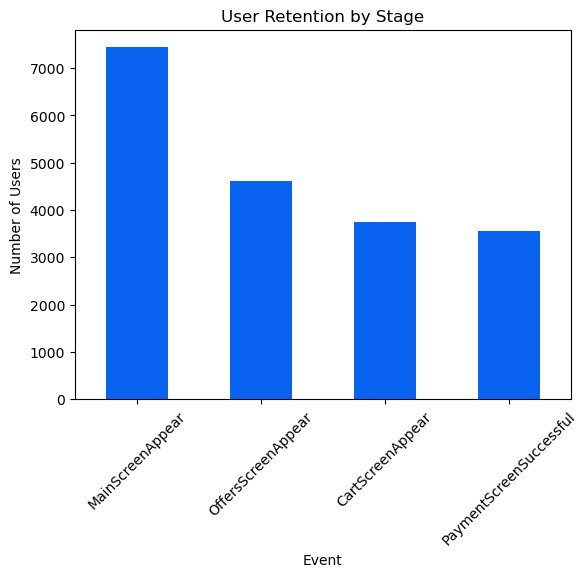

In [18]:
funnel.plot(kind='bar',
           y='users',
           xlabel='Event',
           ylabel='Number of Users',
           legend=False,
           title='User Retention by Stage',
           color='#0a63f0')
plt.xticks(rotation=45)


In [19]:
stage_with_highest_drop = funnel['retention'].idxmin()
drop_value = funnel['retention'].min()

print(f"The stage with the highest drop is: '{stage_with_highest_drop}'")
print(f"Retention at this stage: {drop_value:.2%}")

The stage with the highest drop is: 'OffersScreenAppear'
Retention at this stage: 62.01%


In [20]:
final_step = funnel.index[-1]
final_conversion = funnel.loc[final_step, 'conv_acum']
print(f"The {final_conversion:.2%} of users complete the journey to '{final_step}'")


The 47.68% of users complete the journey to 'PaymentScreenSuccessful'


## Study A/A/B test results

How many users do we have en each group?

In [21]:
df_filtered
user_group = df_filtered.groupby('exp_id')['user_id'].nunique()
display(user_group)

exp_id
246    2485
247    2517
248    2540
Name: user_id, dtype: int64

**Note: Experiment number 246 and 247 are the control groups (A/A), and 248 is the test group(B).** 


Observe whether there is a statistically significant difference between samples 246 and 247.

In [22]:
events = df_filtered['event'].unique()
results = []

for ev in events:
    # users who performed the event ev in each group
    s1 = df_filtered[(df_filtered['exp_id']==246) & (df_filtered['event']==ev)]['user_id'].nunique()
    s2 = df_filtered[(df_filtered['exp_id']==247) & (df_filtered['event']==ev)]['user_id'].nunique()
    # total users in each group
    t1 = df_filtered[df_filtered['exp_id']==246]['user_id'].nunique()
    t2 = df_filtered[df_filtered['exp_id']==247]['user_id'].nunique()

    # z-test for proportions
    count = np.array([s1, s2])
    nobs  = np.array([t1, t2])
    stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
    alpha = 0.05
    results.append({
        'event': ev,
        'p_value': p_value,
        'significant': p_value < alpha
    })

stat_df = pd.DataFrame(results)

display(stat_df)

,event,p_value,significant
0,MainScreenAppear,0.586878,False
1,OffersScreenAppear,0.274351,False
2,Tutorial,0.879161,False
3,PaymentScreenSuccessful,0.112108,False
4,CartScreenAppear,0.213061,False


Find the number of users who performed this action. Find its proportion. Check if the difference between the groups is statistically significant. <br>
Repeat the procedure for all other events (create a function).

In [23]:
#most popular event
top_event = df_filtered['event'].value_counts().idxmax()
print(f"Most popular event: {top_event}")

#test function
def test_event(df, event, group1=246, group2=247):
    # number of unique users who performed the event in each group
    s1 = df[(df.exp_id==group1) & (df.event==event)].user_id.nunique()
    s2 = df[(df.exp_id==group2) & (df.event==event)].user_id.nunique()
    # total unique users in each group
    t1 = df[df.exp_id==group1].user_id.nunique()
    t2 = df[df.exp_id==group2].user_id.nunique()

    # proportions
    p1, p2 = s1/t1, s2/t2

    # z-test for proportions
    count = np.array([s1, s2])
    nobs  = np.array([t1, t2])
    stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
    alpha = 0.05
    return {
        'event':       event,
        'count_246':   s1,
        'count_247':   s2,
        'prop_246':    p1,
        'prop_247':    p2,
        'p_value':     p_value,
        'significant': p_value < alpha
    }


#function for all events
results = [test_event(df_filtered, ev) for ev in events]
stat_df = pd.DataFrame(results)

display(stat_df.sort_values('p_value'))

Most popular event: MainScreenAppear


,event,count_246,count_247,prop_246,prop_247,p_value,significant
3,PaymentScreenSuccessful,1200,1159,0.482897,0.460469,0.112108,False
4,CartScreenAppear,1267,1239,0.509859,0.492253,0.213061,False
1,OffersScreenAppear,1544,1526,0.621328,0.606277,0.274351,False
0,MainScreenAppear,2452,2479,0.986720,0.984903,0.586878,False
2,Tutorial,278,285,0.111871,0.113230,0.879161,False


Compare the results with each control group for each event individually

In [24]:
ctrl_users = df_filtered[df_filtered['exp_id'].isin([246,247])]['user_id'].nunique()
test_results = []

for ev in events:
    # successes in combined control for event ev
    s_ctrl = (
        df_filtered
        .loc[
            df_filtered['exp_id'].isin([246,247]) &
            (df_filtered['event'] == ev),
            'user_id'
        ]
        .nunique()
    )
    # successes and total in test group 248
    s_test = (
        df_filtered
        .loc[
            (df_filtered['exp_id'] == 248) &
            (df_filtered['event'] == ev),
            'user_id'
        ]
        .nunique()
    )
    t_test = df_filtered[df_filtered['exp_id'] == 248]['user_id'].nunique()

    # z-test de proporciones
    stat, p = proportions_ztest(
        count=[s_test, s_ctrl],
        nobs=[t_test, ctrl_users],
        alternative='two-sided'
    )
    alpha = 0.05

    test_results.append({
        'event': ev,
        'prop_248': s_test / t_test,
        'prop_ctrl': s_ctrl / ctrl_users,
        'p_value': p,
        'significant': p < alpha
    })

test_df = pd.DataFrame(test_results).sort_values('p_value')
display(test_df)

,event,prop_248,prop_ctrl,p_value,significant
4,CartScreenAppear,0.486614,0.501000,0.237645,False
0,MainScreenAppear,0.983465,0.985806,0.428973,False
1,OffersScreenAppear,0.604724,0.613754,0.447181,False
3,PaymentScreenSuccessful,0.465748,0.471611,0.629668,False
2,Tutorial,0.111024,0.112555,0.842052,False


The significance level used for the statistical tests was evaluated. Given the number of tests and a 0.1 threshold, the risk of false positives was considered to assess its appropriateness. We re-chech.


In [25]:
alpha=0.05
alpha_bonf = alpha/len(events)
sig_events = test_df[test_df['p_value']<alpha_bonf]
print("Nivel Bonferroni:", alpha_bonf)
print("Eventos con diferencia significativa (post‑Bonferroni):")
display(sig_events)

Nivel Bonferroni: 0.01
Eventos con diferencia significativa (post‑Bonferroni):


,event,prop_248,prop_ctrl,p_value,significant


## Conclusions 
Since no real difference was found — that is, Groups A/A and B behaved in an indistinguishable manner and no statistically significant changes were detected — it is recommended to end the test and retain the current configuration used in Group A.